Regression with PLS
===

Author: Nathan A. Mahynski

Date: 2023/08/23

Description: This is an example of using PLS to create a model, following the procedures outlined in <a href="https://doi.org/10.1021/acs.analchem.9b04611">Detection of Outliers in Projection-Based Modeling," Rodionova and Pomerantsev, Analytical Chemistry 92 (2020) 2656−2664.</a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/api/pls.ipynb)

Figure 1 from this paper illustrates the workflow:

<img src="https://github.com/mahynski/pychemauth/blob/main/docs/_static/pls_example_fig1.png?raw=1" style="width:500px;">

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [ ]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [ ]:
import imblearn
import sklearn

from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

In [ ]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.2.0-34-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

matplotlib: 3.7.2
watermark : 2.4.3
imblearn  : 0.11.0
pandas    : 1.5.3
pychemauth: 0.0.0b3
numpy     : 1.24.3
json      : 2.0.9
sklearn   : 1.3.0



<h3>Utilities for Later</h3>

In [ ]:
def plot_predictions(model, X, y):
    plt.plot(y, model.predict(X).ravel(), 'o')
    plt.plot(y, y, '-')
    plt.xlabel('Actual Salary')
    _ = plt.ylabel('Predicted Salary')

    extremes, outliers = model.check_xy_outliers(X, y)
    plt.plot(
        y[outliers],
        model.predict(X[outliers]),
        color='red',
        marker='x',
        ms=10,
        lw=0,
        label='Outliers'
    )

    plt.plot(
        y[extremes],
        model.predict(X[extremes]),
        color='yellow',
        marker='*',
        ms=10,
        lw=0,
        label='Extreme Values'
    )

    plt.legend(loc='best')

<h3>Load the Data</h3>

Load some example data downloaded from Kaggle [here](https://www.kaggle.com/datasets/mathchi/hitters-baseball-data?select=Hitters.csv).

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/mahynski/pychemauth/main/docs/jupyter/data/Hitters.csv')

In [ ]:
# Let's do a little clean up and only select the numerical columns.
df = df.select_dtypes(include=np.number).dropna()

In [ ]:
df.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:,:-1].values,
    df['Salary'].values, # Let's try to predict the salary based on the other numerical features.
    shuffle=True,
    random_state=42,
    test_size=0.2
)

Fitting a PLS Model
---

In [ ]:
from pychemauth.regressor.pls import PLS

In [ ]:
model = PLS(
    n_components=3,
    alpha=0.05,
    gamma=0.01,
    scale_x=True,
    robust=True, # Use robust methods at first before the data is "clean"
    sft=False
)

_ = model.fit(X_train, y_train)

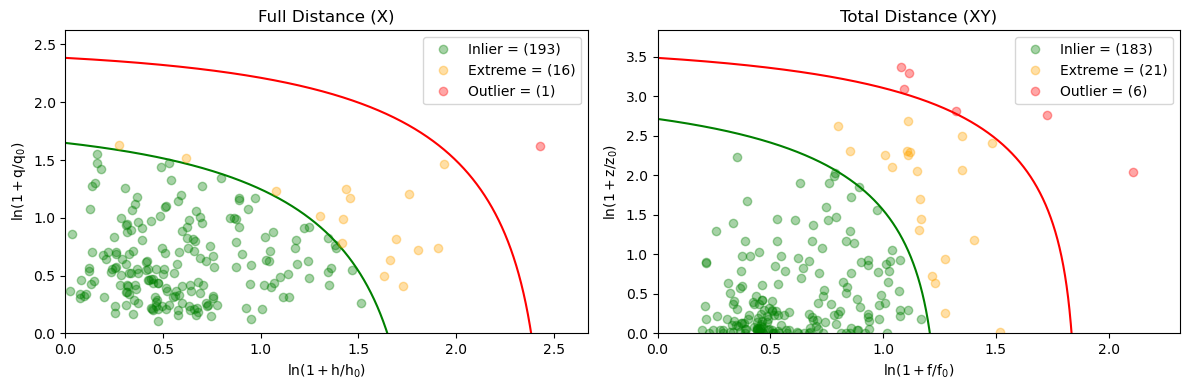

In [ ]:
# Some of the training data might be considered outliers (based on total distance) which can skew the model.
_ = model.visualize(X_train, y_train, figsize=(12,4))

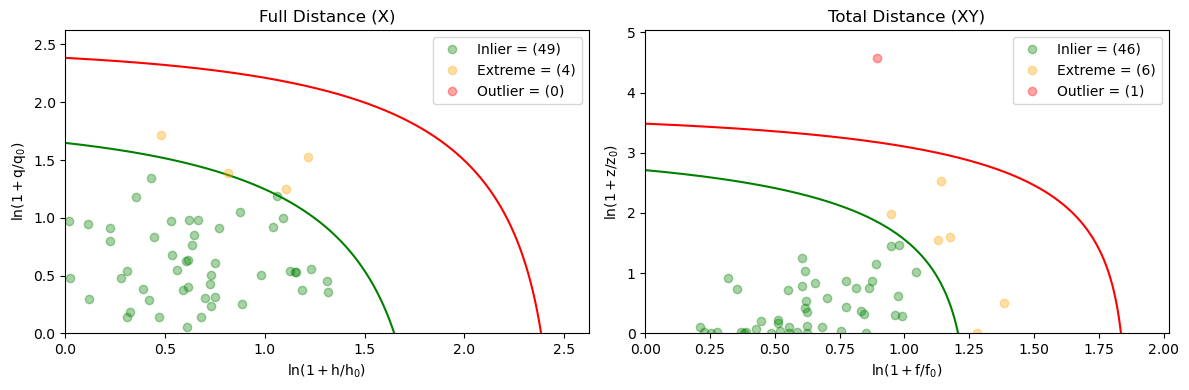

In [ ]:
# There might be 1 outlier in the test set, too.
_ = model.visualize(X_test, y_test, figsize=(12,4))

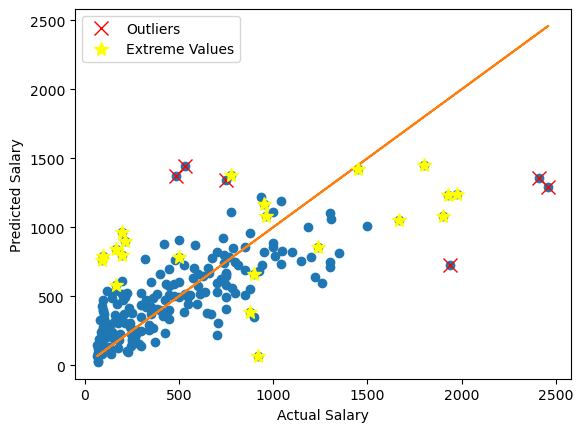

In [ ]:
# The model has picked out many reasonable points to consider outliers (which we shouldn't train using, and don't
# expect the model to perform well on) as well as extreme points.

# Note that based on alpha ~ 0.05 we expect about 5% of the data to be irregular.
plot_predictions(model, X_train, y_train)

Optimizing the Model Without Data Cleaning
---

Let's use a pipeline to optimize the model by searching over many hyperparameters.  This should really only be done when the dataset has been cleaned, but we will proceed here for the sake of illustration.


In [ ]:
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("pls", PLS(n_components=1, alpha=0.05, gamma=0.01, scale_x=True)
    )
])

param_grid = [{
    'pls__n_components':np.arange(1, 10),
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.KFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, y_train)

In [ ]:
# The best parameters found can be accessed like this.
gs.best_params_

{'pls__n_components': 1}

In [ ]:
gs.best_score_ # The best (default is R^2, coefficient of determination) score it recieved was.

0.4263544920180595

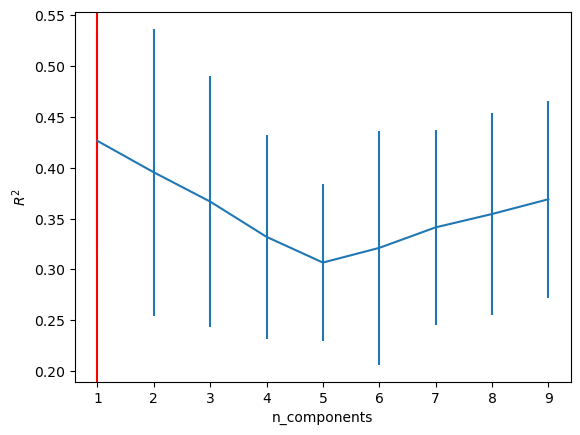

In [ ]:
# For a 1D optimization like this (only optimizing the number of components) you can easily visualize where the best
# value occurs.
plt.errorbar(gs.cv_results_['param_pls__n_components'].data,
             gs.cv_results_['mean_test_score'],
             yerr=gs.cv_results_['std_test_score'])
plt.xlabel('n_components')
plt.ylabel(r'$R^2$')

_ = plt.axvline(gs.best_params_['pls__n_components'], color='red')

In [ ]:
# The refit=True (default) refits the model on the entire training set in the end so you can use it directly.
gs.score(X_test, y_test)

0.12406291855662177

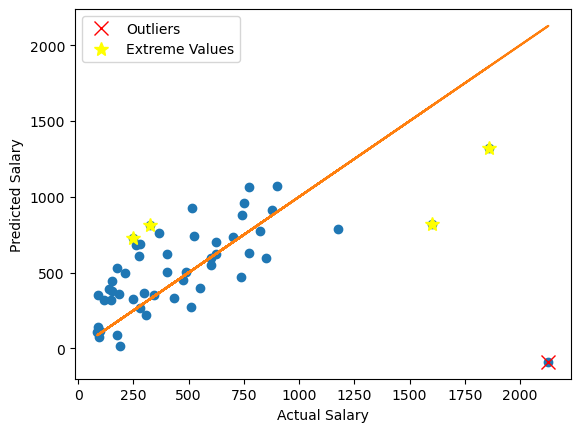

In [ ]:
plot_predictions(gs.best_estimator_.named_steps['pls'], X_test, y_test)

Outlier Detection
---

Steps 1 and 2 in the workflow at the beginning of this document are handled by the last step with CV. Now we can turn to optimizing the training set by removing outliers.  Let's use the same model as in the last example.


In [ ]:
optimal_model = PLS(n_components=1, alpha=0.05, gamma=0.01, scale_x=True)
_ = optimal_model.fit(X_train, y_train)

<h3>Step 3</h3>

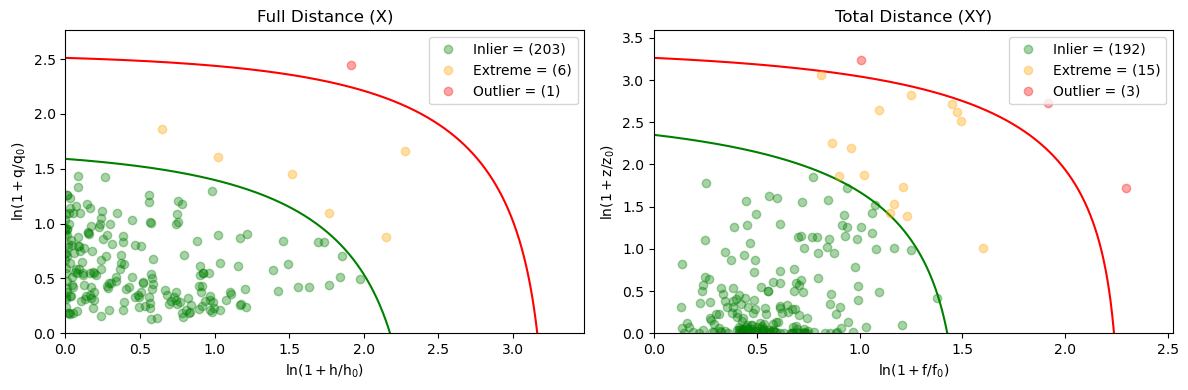

In [ ]:
_ = optimal_model.visualize(X_train, y_train, figsize=(12,4))

In [ ]:
# Let's look at how many outliers we have.
extremes, outliers = optimal_model.check_xy_outliers(X_train, y_train)
np.sum(outliers) # Indeed, we have 1 outlier

3

In [ ]:
# Let's start collecting these outliers.
X_out = X_train[outliers, :]
y_out = y_train[outliers]

<h3>Step 4</h3>

In [ ]:
# Select data that is NOT an outlier (inlier and extreme points, or "regular" points) to use for training.
X_train_new = X_train[~outliers]
y_train_new = y_train[~outliers]

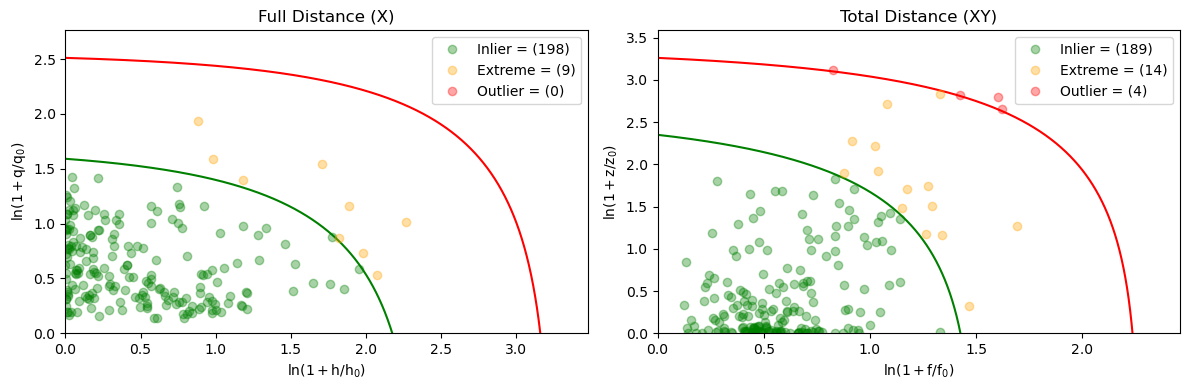

In [ ]:
# Train again - once more, we see there are outliers.
_ = optimal_model.fit(X_train_new, y_train_new)
_ = optimal_model.visualize(X_train_new, y_train_new, figsize=(12,4))

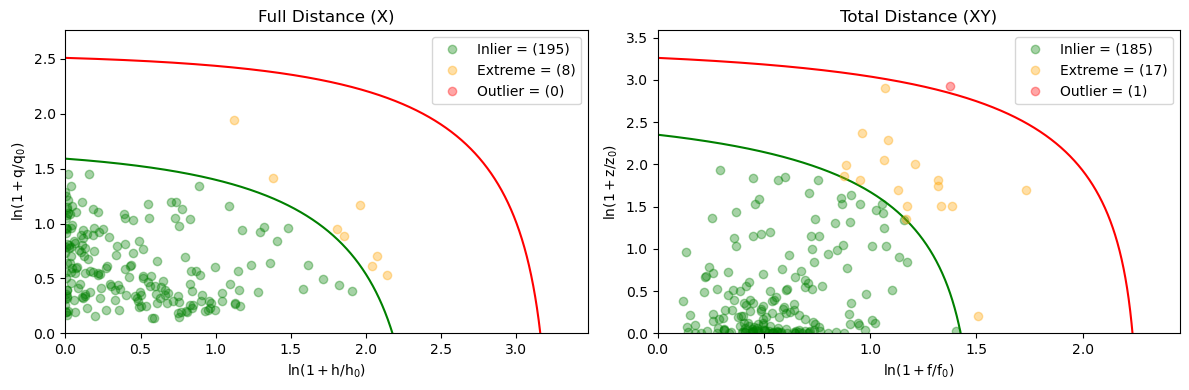

In [ ]:
# Once again, get the outliers, continue to collect them, and train again on the updated dataset
extremes, outliers = optimal_model.check_xy_outliers(X_train_new, y_train_new)

X_out = np.vstack((X_out, X_train_new[outliers,:]))
y_out = np.concatenate((y_out, y_train_new[outliers]))

X_train_new = X_train_new[~outliers]
y_train_new = y_train_new[~outliers]

_ = optimal_model.fit(X_train_new, y_train_new)
_ = optimal_model.visualize(X_train_new, y_train_new, figsize=(12,4))

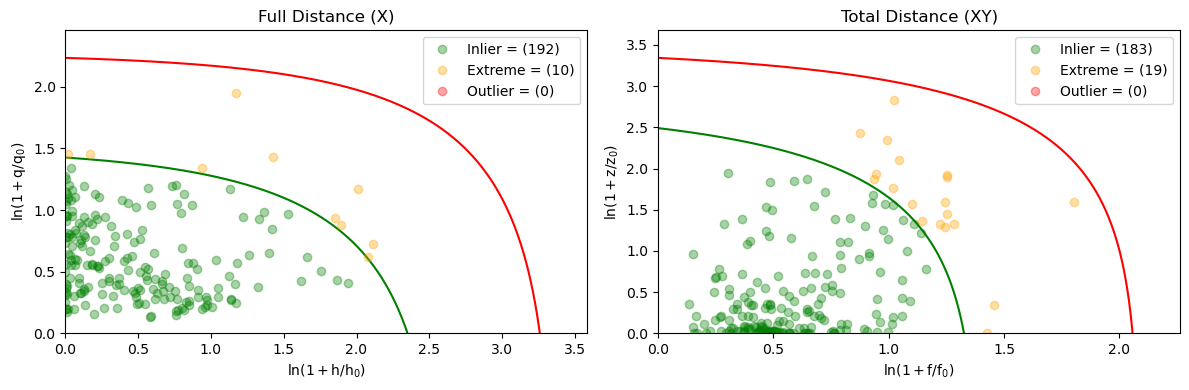

In [ ]:
# There is still 1 outlier, so let's repeat the last cell's code again.
extremes, outliers = optimal_model.check_xy_outliers(X_train_new, y_train_new)

X_out = np.vstack((X_out, X_train_new[outliers,:]))
y_out = np.concatenate((y_out, y_train_new[outliers]))

X_train_new = X_train_new[~outliers]
y_train_new = y_train_new[~outliers]

_ = optimal_model.fit(X_train_new, y_train_new)
_ = optimal_model.visualize(X_train_new, y_train_new, figsize=(12,4))

In [ ]:
# The inner loop is done and we have a candidate "clean" dataset.
# Here are the points we removed so far.
X_out

array([[  495,   151,    17,    61,    84,    78,    10,  5624,  1679,
          275,   884,  1015,   709,  1045,    88,    13],
       [  419,   101,    18,    65,    58,    92,    20,  9528,  2510,
          548,  1509,  1659,  1342,     0,     0,     0],
       [  237,    52,     0,    15,    25,    30,    24, 14053,  4256,
          160,  2165,  1314,  1566,   523,    43,     6],
       [  514,   144,     0,    67,    54,    79,     9,  4739,  1169,
           13,   583,   374,   528,   229,   453,    15],
       [  677,   238,    31,   117,   113,    53,     5,  2223,   737,
           93,   349,   401,   171,  1377,   100,     6],
       [  354,    77,    16,    36,    55,    41,    20,  8716,  2172,
          384,  1172,  1267,  1057,    83,   174,    16],
       [  507,   122,    29,    78,    85,    91,    18,  7761,  1947,
          347,  1175,  1152,  1380,   808,   108,     2],
       [  618,   200,    20,    98,   110,    62,    13,  7127,  2163,
          351,  1104,  128

<h3>Step 5</h3>

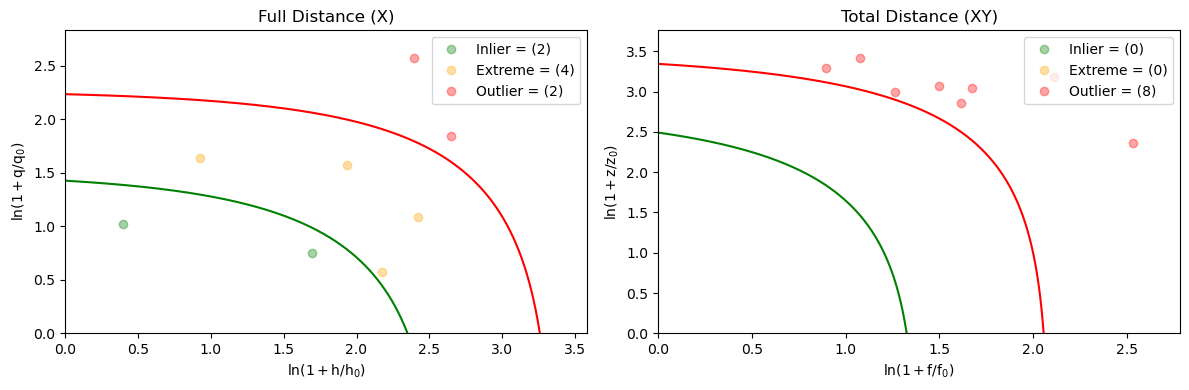

In [ ]:
# Let's check if the outliers we iteratively collected are still all considered outliers.
# Indeed, they are so we do not need to go back to step 6 and repeat the loop above.
_ = optimal_model.visualize(X_out, y_out, figsize=(12,4))

In [ ]:
extremes, outliers = optimal_model.check_xy_outliers(X_out, y_out)

In [ ]:
np.all(outliers)

True

<h3>Step 7</h3>

In [ ]:
final_model = PLS(
    n_components=1,
    alpha=0.05,
    gamma=0.01,
    scale_x=True,
    robust=False, # Now that the dataset is considered "clean" we need should use classical statistical methods
    sft=False
)

_ = final_model.fit(X_train_new, y_train_new)

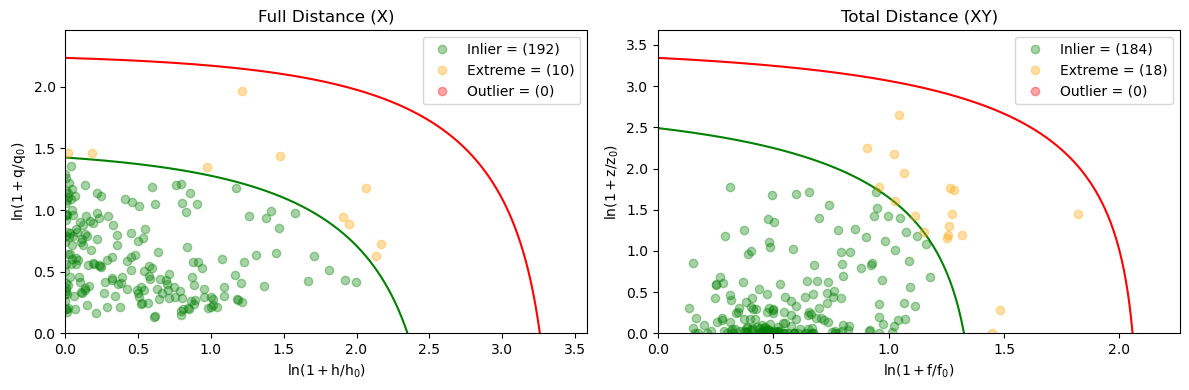

In [ ]:
_ = final_model.visualize(X_train_new, y_train_new, figsize=(12,4))

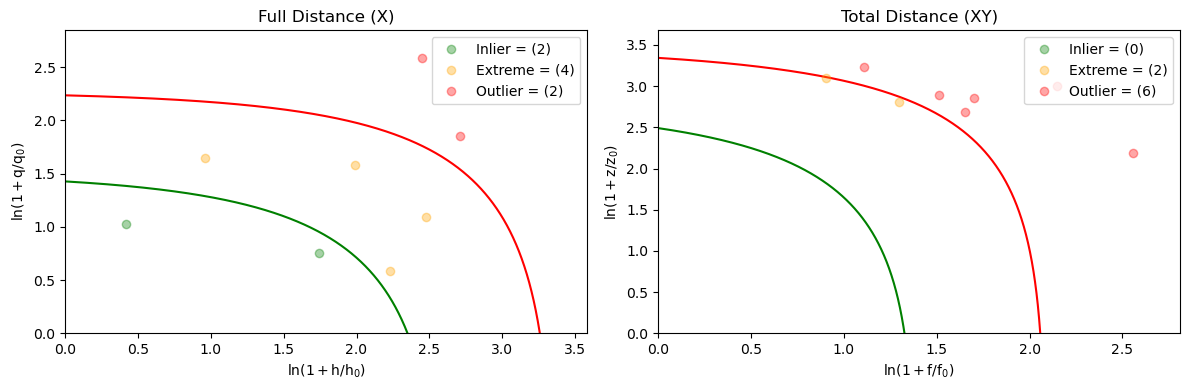

In [ ]:
# The classical model accepts a few outliers as extremes, but only barely.  These were determined to be outliers by
# a robust version of this model.
_ = final_model.visualize(X_out, y_out, figsize=(12,4))

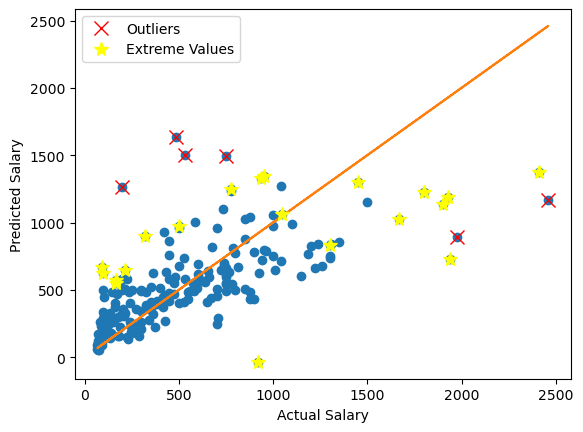

In [ ]:
plot_predictions(final_model, X_train, y_train)

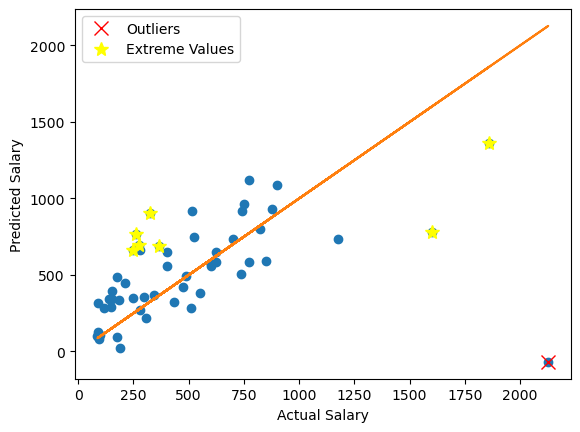

In [ ]:
plot_predictions(final_model, X_test, y_test)

<h3>Automatic Loop</h3>

That was a lot of manual work and code-copying.  It would be nice to have all of that automated, and in fact, the `sft` option does just that.


In [ ]:
# The 'robust' option will be ignored here - robust=True is used during the cleaning, but after the dataset is cleaned
# the final model will be re-trained the clean dataset using robust=False

auto_model = PLS(
    n_components=1,
    alpha=0.05,
    gamma=0.01,
    scale_x=True,
    robust=True, # Will be ignored
    sft=True
)

_ = auto_model.fit(X_train, y_train)

In [ ]:
auto_model.sft_history # These are the points we removed manually!

{'outer_loops': 1,
 'removed': {'X': array([[495, 151, 17, 61, 84, 78, 10, 5624, 1679, 275, 884, 1015, 709,
          1045, 88, 13],
         [419, 101, 18, 65, 58, 92, 20, 9528, 2510, 548, 1509, 1659, 1342,
          0, 0, 0],
         [237, 52, 0, 15, 25, 30, 24, 14053, 4256, 160, 2165, 1314, 1566,
          523, 43, 6],
         [514, 144, 0, 67, 54, 79, 9, 4739, 1169, 13, 583, 374, 528, 229,
          453, 15],
         [677, 238, 31, 117, 113, 53, 5, 2223, 737, 93, 349, 401, 171,
          1377, 100, 6],
         [354, 77, 16, 36, 55, 41, 20, 8716, 2172, 384, 1172, 1267, 1057,
          83, 174, 16],
         [507, 122, 29, 78, 85, 91, 18, 7761, 1947, 347, 1175, 1152, 1380,
          808, 108, 2],
         [618, 200, 20, 98, 110, 62, 13, 7127, 2163, 351, 1104, 1289, 564,
          330, 16, 8]], dtype=object),
  'y': array([2460.0, 487.5, 750.0, 1940.0, 1975.0, 200.0, 535.0, 2412.5],
        dtype=object)},
 'iterations': {1: {'initially removed X': array([[  495,   151,    17,    

In [ ]:
np.allclose(
    np.asarray(auto_model.sft_history['removed']['X'], dtype=np.float64),
    np.asarray(X_out, dtype=np.float64)
)

True

In [ ]:
np.allclose(
    np.asarray(auto_model.sft_history['removed']['y'], dtype=np.float64),
    np.asarray(y_out, dtype=np.float64)
)

True

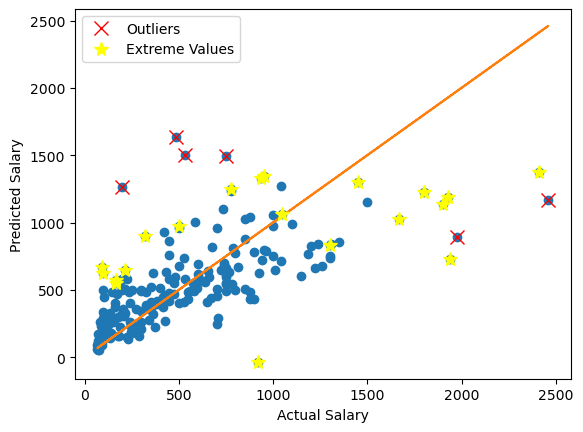

In [ ]:
plot_predictions(auto_model, X_train, y_train)

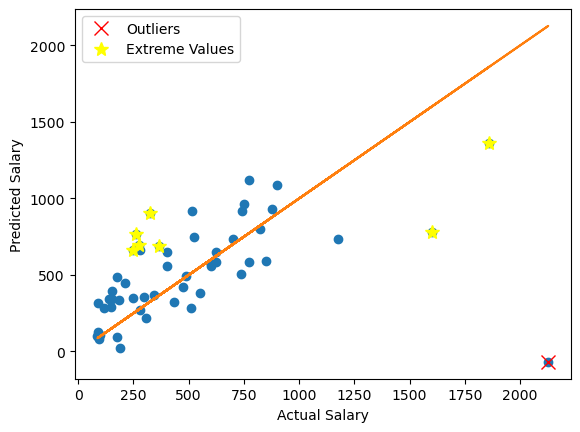

In [ ]:
plot_predictions(auto_model, X_test, y_test)

Optimizing the Model With Data Cleaning
---

With the 'sft' option we can use pipelines to optimize the models which internally use this data cleaning.  It would be a lot of work to do all of the above manually inside a cross-validation loop!


In [ ]:
pipeline = imblearn.pipeline.Pipeline(steps=[
    ("pls",
     PLS(
         n_components=1,
         alpha=0.05,
         gamma=0.01,
         scale_x=True,
         sft=True
     )
    )
])

param_grid = [{
    'pls__n_components':np.arange(1, 10),
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.KFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, y_train)

In [ ]:
# A few fits still fail because they are not able to perfectly clean the dataset since the loops shown in the figure
# do not converge.  Still, we are able to get generally good performance, and in this case we obtain the same result.
gs.best_params_

{'pls__n_components': 1}

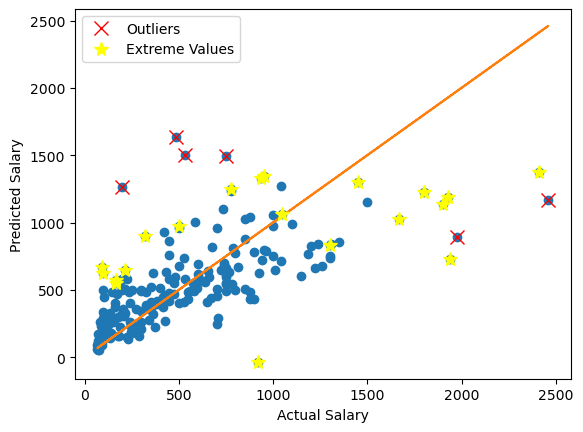

In [ ]:
plot_predictions(gs.best_estimator_.named_steps['pls'], X_train, y_train)

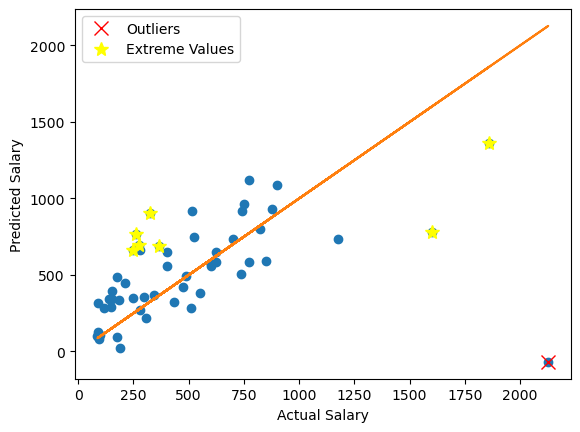

In [ ]:
plot_predictions(gs.best_estimator_.named_steps['pls'], X_test, y_test)

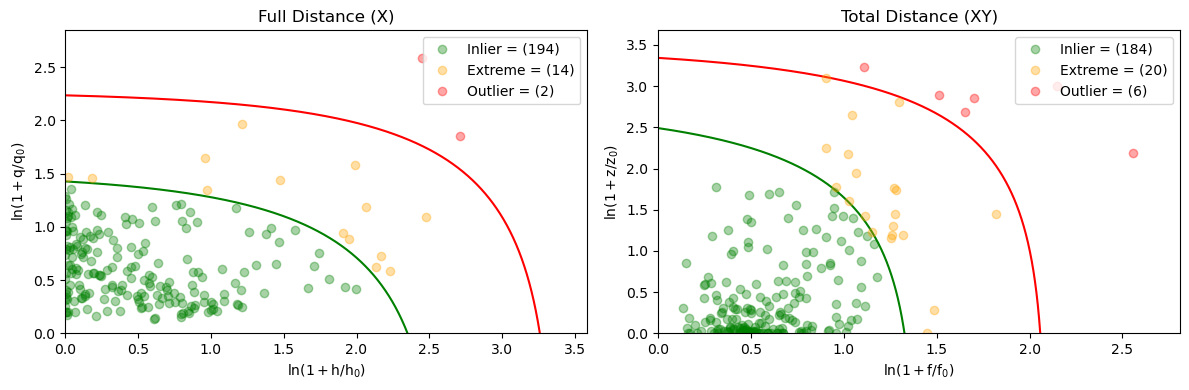

In [ ]:
_ = final_model.visualize(X_train, y_train, figsize=(12,4))

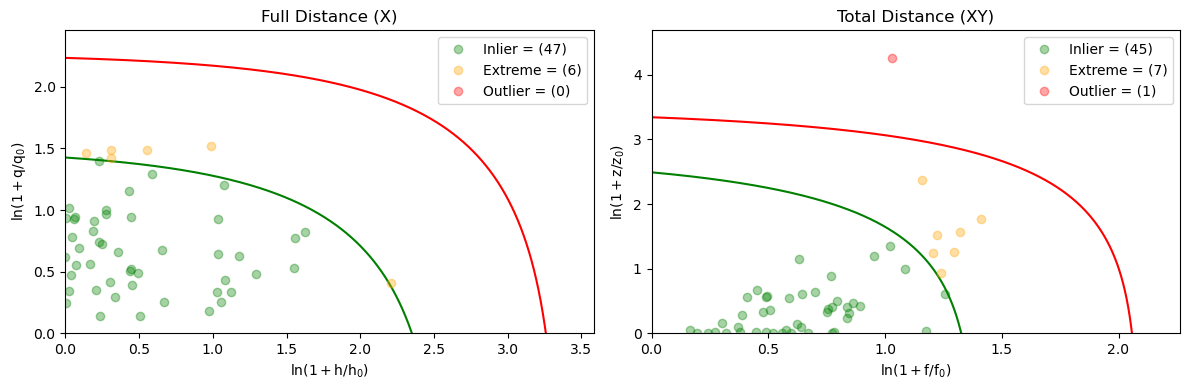

In [ ]:
_ = final_model.visualize(X_test, y_test, figsize=(12,4))